# CQF - Final Project

## Optimal Hedging with Advanced Greeks

### Imports

In [2]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from statistics import mean
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
%matplotlib inline

### Simple Volatility Arbitrage but improved Asset Evolution

We will use the geometric Brownian motion (GBM), thus this mens the stock price follows a random walk and is consistent with the weak form of the efficient market hypothesis (EMH) - past price information is already incorporated, and the next price movement is "conditionally independent" of past price movements.

The formula for GBM is found below:

$$
\Delta S = S \mu \delta t + S \sigma \epsilon \sqrt{\Delta t}
$$

**where:**

$$
\begin{align*}
S &= \text{the stock price} \\
\Delta S &= \text{the change in stock price} \\
\mu &= \text{the expected return} \\
\sigma &= \text{the standard deviation of returns} \\
\epsilon &= \text{the random variable} \\
\Delta t &= \text{the elapsed time period} \\
\end{align*}

### Variance Reduction

In order to get a realistic comparison we will fixed the seed value for random number generator 

In [13]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31* '-')
for i in range(1, 31, 2):
    np.random.seed(100)
    sn = np.random.standard_normal(i ** 2 * 10000)
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
 0.001150944833  1.006296354600
 0.002841204001  0.995987967146
 0.001998082016  0.997701714233
 0.001322322067  0.997771186968
 0.000592711311  0.998388962646
-0.000339730751  0.998399891450
-0.000228109010  0.998657429396
 0.000295768719  0.998877333340
 0.000257107789  0.999284894532
-0.000357870642  0.999456401088
-0.000528443742  0.999617831131
-0.000300171536  0.999445228838
-0.000162924037  0.999516059328
 0.000135778889  0.999611052522
 0.000182006048  0.999619405229


The result shows that the statistics get better the larger the sample size. However it does not still match.

The *antithetic variates* technic consists in draws only half the desired number of random draws, and adds the same set of random numbers with the opposite sign afterward. The described method works for sysmmetric median 0 random variables only, like standard normally distributed random variables, which are almost exclusively used throughout. 

In [21]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31* '-')
for i in range(1, 31, 2):
    np.random.seed(100)
    sn = np.random.standard_normal(i ** 2 * int(10000 / 2))
    sn = np.concatenate((sn, -sn))
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
-0.000000000000  1.017474904235
 0.000000000000  0.998944776883
 0.000000000000  0.998018870658
 0.000000000000  0.997916558845
-0.000000000000  0.998119811838
 0.000000000000  0.998365584578
 0.000000000000  0.998171301115
-0.000000000000  0.998359568664
-0.000000000000  0.998772594780
-0.000000000000  0.998640403762
 0.000000000000  0.998868127277
 0.000000000000  0.999102053335
 0.000000000000  0.999342143561
 0.000000000000  0.999449673443
-0.000000000000  0.999613960655


This results in a mean value of zero, even in smaller sample sizes.

In [12]:
def generate_random(N):
    np.random.randn(N/2)*np.sqrt(dt)

NameError: name 'a' is not defined

In [4]:
S0 = 100.0
T = 1.0
sigma_a = 0.35
sigma_i = 0.20
r = 0.02
N = 100
dt = T / N
ts = np.arange(0, T, dt)
dB = np.concatenate((np.zeros(1), np.random.randn(N-1)*np.sqrt(dt)))
B = np.cumsum(dB)

#### Euler-Maruyama scheme

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B
$$

In [3]:
def euler_maruyama_scheme(S0, ts, sigma, r, dt, dB):
    S = np.zeros(len(ts))
    S[0] = S0

    for i in range(1, len(ts)):
        S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i]

    return pd.DataFrame(index=ts, data=S, columns=['prices'])

(          prices
 0.00  100.000000
 0.01   98.040149
 0.02   96.456518
 0.03  101.876562
 0.04  101.129112
 ...          ...
 0.95   98.994684
 0.96   97.711339
 0.97  101.223400
 0.98  102.783087
 0.99  102.425346
 
 [100 rows x 1 columns],
 <AxesSubplot:>)

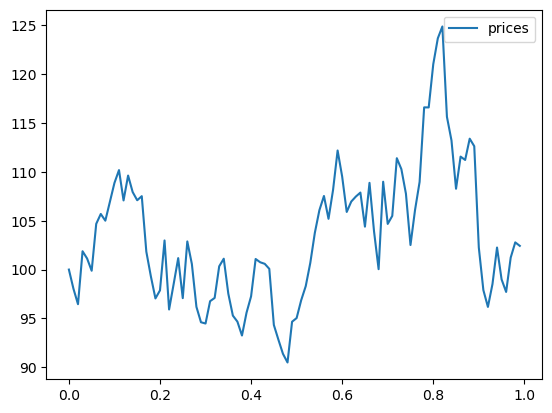

In [7]:
df = euler_maruyama_scheme(S0, ts, sigma_a, r, dt, dB)
df, df.plot()

#### Milstein scheme

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B + \frac{1}{2}\sigma^{2} S_{n} (\Delta B^{2} - \Delta t)
$$

In [8]:
def milstein_scheme(S0, ts, sigma, r, dt, dB):
    S = np.zeros(len(ts))
    S[0] = S0

    for i in range(1, len(ts)):
        S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i] \
            + 0.5*(sigma**2)*S[i-1]*(dB[i]**2-dt)

    return pd.DataFrame(index=ts, data=S, columns=['prices'])

(          prices
 0.00  100.000000
 0.01   97.998498
 0.02   96.368619
 0.03  101.875759
 0.04  101.068809
 ...          ...
 0.95   98.359384
 0.96   97.032552
 0.97  100.522767
 0.98  102.021712
 0.99  101.604825
 
 [100 rows x 1 columns],
 <AxesSubplot:>)

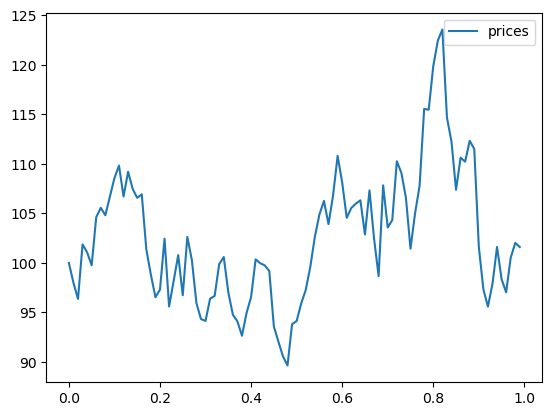

In [9]:
df = milstein_scheme(S0, ts, sigma_a, r, dt, dB)
df, df.plot()

## References
- [Investopedia - Monte Carlo](https://www.investopedia.com/articles/07/montecarlo.asp)
- HILPISCH, Yves. **Python for Finance: Mastering Data-driven Finance**. 2. ed. O'Reilly Media, 2019.